# **SIAMESE NETWORK WITH TRIPLET LOSS**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Import helper classes**

In [ ]:
%cd "/content/drive/My Drive/FinalProject/CodeBase/"

# install import-ipynb for importing helper modules
!pip install import-ipynb
import import_ipynb

# importing helper functions for data preprocessing and model visualization
import plotlib_helper as gplot
import datapreprocess_helper as dataprep

/content/drive/My Drive/FinalProject/CodeBase


## **Plotting functions**

In [ ]:
import matplotlib.patheffects as PathEffects
from keras.utils import plot_model

# Define our own plot function
def scatter(x, labels, subtitle=None):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("deep", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[labels.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(2):
        # Position of each label.
        xtext, ytext = np.median(x[labels == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
        
    if subtitle != None:
        plt.suptitle(subtitle)
        
    plt.savefig(subtitle)

In [ ]:
data_path = "/content/drive/My Drive/FinalProject/CodeBase/data/"
dnn_path = "/content/drive/My Drive/FinalProject/CodeBase/dnn/"

## **Load data**

In [ ]:
import pandas as pd
import io
import os
import requests
import numpy as np
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
import random

filepath = os.path.join(data_path, "Raw_data.csv")
df = pd.read_csv(filepath, na_values=['NA','?','-'])
df

,AGE,SEX,BMI,OPEN_LAP,DM,TUMOR_SIZE,AFP,RAS,WBC,HB,PLT,CR,ALB,AST,ALT,GLU,CHOLESTEROL,CRYSTALLOID,PRBC,SURG_DURATION,KDIGO
0,64,0,23.3,0,0,1.200000,193.00000,0,4.1,12.9,113,0.70,3.7,36,35,128,197,1800,0,214,0
1,57,1,28.9,0,0,1.500000,6.10000,0,5.2,14.1,140,1.00,4.0,25,24,111,125,500,0,240,0
2,45,1,29.7,0,0,1.700000,1120.00000,0,4.5,16.4,100,0.90,4.6,30,29,91,146,3100,0,287,1
3,57,1,23.8,0,0,6.600000,16.00000,0,5.9,11.1,320,0.52,3.0,52,48,138,93,1250,0,260,0
4,51,1,23.6,0,1,1.007298,68.70000,0,5.0,15.1,130,0.90,3.9,29,34,238,199,1800,0,186,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1168,44,1,25.0,1,0,2.200000,0.87000,0,4.9,14.3,135,0.84,3.9,20,14,96,125,2200,0,246,0
1169,57,1,23.5,1,0,2.300000,3.50000,0,5.9,14.9,132,0.69,3.7,31,40,142,151,750,0,199,0
1170,49,1,21.4,1,0,1.800000,2.90000,0,6.8,14.6,202,1.03,4.8,19,11,95,141,1400,0,161,0
1171,43,1,26.6,1,0,5.434272,68546.75843,0,7.0,16.0,204,0.90,3.9,19,17,91,167,1000,0,164,0


In [ ]:
 df_Y = df['KDIGO'].copy() # copying the target column

## **Normalization and Encoding**

In [ ]:
normalize_cols = ['AGE', 'BMI','TUMOR_SIZE', 'AFP', 'RAS', 'WBC',	'HB',	'PLT', 'CR','ALB','AST','ALT','GLU', 'CHOLESTEROL', 'CRYSTALLOID','PRBC',	'SURG_DURATION']
categorical_cols = ['SEX','OPEN_LAP', 'DM']

for col in categorical_cols:
  dataprep.encode_text_dummy(df, col)
for col in normalize_cols:
  df[col].astype('float64')
  dataprep.encode_numeric_zscore(df, col)

In [ ]:
df_X = df.drop(columns=['KDIGO'], inplace=False)

In [ ]:
df #after encoding

,AGE,BMI,TUMOR_SIZE,AFP,RAS,WBC,HB,PLT,CR,ALB,AST,ALT,GLU,CHOLESTEROL,CRYSTALLOID,PRBC,SURG_DURATION,KDIGO,SEX-0,SEX-1,OPEN_LAP-0,OPEN_LAP-1,DM-0,DM-1
0,0.811163,-0.325363,-0.894353,-0.149907,-0.429757,-0.743320,-0.653869,-0.763298,-0.742450,-0.254106,-0.123957,-0.073318,0.202328,0.951455,-0.471385,-0.188005,-0.702916,0,1,0,1,0,1,0
1,0.127689,1.637571,-0.814569,-0.152852,-0.429757,-0.123302,0.101041,-0.358814,1.001663,0.473477,-0.483055,-0.464557,-0.158003,-1.091513,-1.793512,-0.188005,-0.382575,0,0,1,1,0,1,0
2,-1.043983,1.917990,-0.761380,-0.135299,-0.429757,-0.517859,1.547951,-0.958050,0.420292,1.928642,-0.319829,-0.286721,-0.581922,-0.495648,0.850743,-0.188005,0.196503,1,0,1,1,0,1,0
3,0.127689,-0.150101,0.541758,-0.152696,-0.429757,0.271255,-1.786234,2.337750,-1.788918,-1.951799,0.398366,0.389056,0.414288,-1.999499,-1.030746,-0.188005,-0.136159,0,0,1,1,0,1,0
4,-0.458147,-0.220205,-0.945602,-0.151865,-0.429757,-0.236032,0.730132,-0.508623,0.420292,0.230949,-0.352474,-0.108885,2.533884,1.008204,-0.471385,-0.188005,-1.047898,0,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1168,-1.141622,0.270528,-0.628407,-0.152934,-0.429757,-0.292398,0.226859,-0.433718,0.071470,0.230949,-0.646281,-0.820230,-0.475942,-1.091513,-0.064576,-0.188005,-0.308650,0,0,1,0,1,1,0
1169,0.127689,-0.255258,-0.601812,-0.152893,-0.429757,0.271255,0.604314,-0.478661,-0.800587,-0.254106,-0.287183,0.104519,0.499072,-0.353775,-1.539257,-0.188005,-0.887728,0,0,1,0,1,1,0
1170,-0.653426,-0.991358,-0.734785,-0.152902,-0.429757,0.778542,0.415586,0.570003,1.176075,2.413697,-0.678926,-0.926931,-0.497138,-0.637520,-0.878193,-0.188005,-1.355918,0,0,1,0,1,1,0
1171,-1.239261,0.831366,0.231737,0.927240,-0.429757,0.891272,1.296315,0.599964,0.420292,0.230949,-0.678926,-0.713528,-0.581922,0.100218,-1.285002,-0.188005,-1.318956,0,0,1,0,1,1,0


## **Converting into tensors**

### **For Triplet Creation**

In [ ]:
from imblearn.combine import SMOTETomek

print("Before OverSampling",df_X.shape , df_Y.shape)
#print(f"Frequency of classes: {pd.value_counts(y_train_small.flatten()#)}")

smk = SMOTETomek(random_state=24)
x_train_oversample, y_train_oversample = smk.fit_sample(df_X, df_Y)

print("After OverSampling",x_train_oversample.shape , y_train_oversample.shape)
#print(f"Frequency of classes after oversampling: {pd.value_counts(y_train)}")

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Before OverSampling (1173, 23) (1173,)
After OverSampling (2192, 23) (2192,)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
pd.value_counts(y_train_oversample)

1    1096
0    1096
dtype: int64

In [ ]:
np_classes_oversample = y_train_oversample.copy()

In [ ]:
np_X, np_Y = dataprep.to_xy(df,'KDIGO')

In [ ]:
np_X.shape, np_Y.shape #numpy arrays

((1173, 23), (1173, 2))

##### **For Prediction purpose - converting target column to numpy array**

In [ ]:
np_classes = np.array(df_Y)
np_classes.shape

(1173,)

## **Train-Test Split**

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test, np_classes_train, np_classes_test = train_test_split(np_X, np_Y, np_classes, test_size=0.3, random_state=45)

## **Embedding before training through Siamese Net**

#### **Embedding for train set**

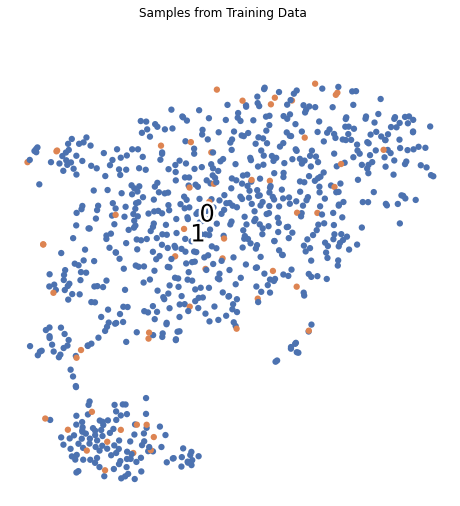

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE()
train_embeds = tsne.fit_transform(x_train)
scatter(train_embeds, np_classes_train, "Samples from Training Data")

#### **Embedding for test set**

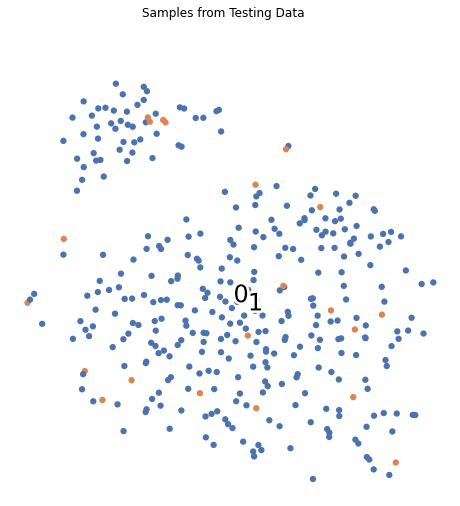

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE()
test_embeds = tsne.fit_transform(x_test)
scatter(test_embeds, np_classes_test, "Samples from Testing Data")

In [ ]:
# np_X = np_X.reshape(np_X.shape[0], 1, 23, 1)
# np_X.shape

## **Triplet Batch Function**

##### **CASE 1: Random Triplet Selection**

In [ ]:
def generate_triplet_v1(batch_size):
  triplet_train_pairs = []
  triplet_test_pairs = []

  for i in range (5000):
    index = random.randint(0, len(x_train)-1)
    anc = x_train[index]
    classtype = np_classes_train[index]
        
    pos_indices = np.squeeze(np.where(np_classes_train == classtype))
    neg_indices = np.squeeze(np.where(np_classes_train != classtype))
        
    pos = x_train[pos_indices[random.randint(0, len(pos_indices)-1)]]
    neg = x_train[neg_indices[random.randint(0, len(neg_indices)-1)]]
        
    Anchor = anc.reshape(1, 23, 1)
    Positive = pos.reshape(1, 23, 1)
    Negative = neg.reshape(1, 23, 1)
    triplet_train_pairs.append([Anchor,Positive,Negative])
  
  for i in range (1000):
    index = random.randint(0, len(x_test)-1)
    anc = x_test[index]
    classtype = np_classes_test[index]
        
    pos_indices = np.squeeze(np.where(np_classes_test == classtype))
    neg_indices = np.squeeze(np.where(np_classes_test != classtype))
        
    pos = x_test[pos_indices[random.randint(0, len(pos_indices)-1)]]
    neg = x_test[neg_indices[random.randint(0, len(neg_indices)-1)]]
        
    Anchor = anc.reshape(1, 23, 1)
    Positive = pos.reshape(1, 23, 1)
    Negative = neg.reshape(1, 23, 1)
    triplet_test_pairs.append([Anchor,Positive,Negative])

  return np.array(triplet_train_pairs), np.array(triplet_test_pairs)

##### **CASE 2: Triplet variation - APN created with N joined for each AP pairs**

In [ ]:
from itertools import permutations
import random
def generate_triplet_v2(x, classes, testsize=0.3, ap_pairs=10, an_pairs=10):

    trainsize = 1-testsize

    triplet_train_pairs = []
    triplet_test_pairs = []

    for data_class in sorted(set(classes)):

        same_class_idx = np.where((classes == data_class))[0]
        diff_class_idx = np.where(classes!= data_class)[0]
      
        A_P_pairs = random.sample(list(permutations(same_class_idx,2)),k=ap_pairs) 
        Neg_idx = random.sample(list(diff_class_idx),k=an_pairs)
       
        #TRAIN----------------------------------------------------------
        A_P_len = len(A_P_pairs)
        Neg_len = len(Neg_idx)

        for ap in A_P_pairs[:int(A_P_len*trainsize)]:
            
            Anchor=x[ap[0]]
            Positive=x[ap[1]]
           
            for n in Neg_idx:

                Negative =x[n]
                triplet_train_pairs.append([Anchor,Positive,Negative])    
                       
        #TEST------------------------------------------------------------
        for ap in A_P_pairs[int(A_P_len*trainsize):]:

            Anchor=x[ap[0]] 
            Positive = x[ap[1]]

            for n in Neg_idx:

                Negative =x[n]
                triplet_test_pairs.append([Anchor,Positive,Negative])      
                
        
    print("Successfully generated train and test triplets....")

    return np.array(triplet_train_pairs), np.array(triplet_test_pairs)

## **Triplet Loss Functions**

##### **VERSION 1**

In [ ]:
def triplet_loss_v1(alpha, emb_dim):
    def loss(y_true, y_pred):
        anc, pos, neg = y_pred[:,:emb_size], y_pred[:,emb_size:2*emb_size], y_pred[:,2*emb_size:]
        distance1 = tf.sqrt(tf.reduce_sum(tf.pow(anc - pos, 2), 1, keepdims=True))
        distance2 = tf.sqrt(tf.reduce_sum(tf.pow(anc - neg, 2), 1, keepdims=True))
        return tf.reduce_mean(tf.maximum(distance1 - distance2 + alpha, 0.))
    return loss

##### **VERSION 2**

In [ ]:
def triplet_loss_v2(alpha, emb_dim):
  def loss(y_true,y_pred):
    anc, pos, neg = y_pred[:, 0:emb_dim], y_pred[:, emb_dim:2*emb_dim], y_pred[:, 2*emb_dim:]
    dp = tf.reduce_mean(tf.square(anc-pos), axis=1)
    dn = tf.reduce_mean(tf.square(anc-neg), axis=1)
    return tf.maximum(dp - dn + alpha, 0.)
  return loss

##### **VERSION 3**

In [ ]:
def triplet_loss_v3(alpha, emb_dim):
    def loss(y_true, y_pred):
        anc, pos, neg = y_pred[:,:emb_size], y_pred[:,emb_size:2*emb_size], y_pred[:,2*emb_size:]
        distance1 = tf.keras.losses.cosine_similarity(anc, pos)
        distance2 = tf.keras.losses.cosine_similarity(anc, neg)
        return tf.keras.backend.clip(distance1 - distance2 + alpha, 0., None)
    return loss

## **Data Generator**

In [ ]:
def data_generator_train(batch_size, emb_size):
    while True:
        x = get_triplet_batch_train(batch_size)
        y = np.zeros((batch_size, 3*emb_size))
        yield x,y

In [ ]:
def data_generator_test(batch_size, emb_size):
    while True:
        x = get_triplet_batch_test(batch_size)
        y = np.zeros((batch_size, 3*emb_size))
        yield x,y

## **Embedding Model**

#### **Embedding Size**

In [ ]:
emb_size = 128

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Conv2D, Flatten, MaxPooling2D, Dropout, concatenate, Lambda, BatchNormalization
from tensorflow.keras.utils import plot_model
import tensorflow as tf

embedding_model = Sequential()
embedding_model.add(Conv2D(64, (1,5),activation='relu', input_shape=(1, 23, 1)))
embedding_model.add(BatchNormalization())
embedding_model.add(MaxPooling2D(pool_size=(1, 2), padding="same"))
embedding_model.add(Dropout(0.2))
embedding_model.add(Conv2D(128, (1,5), activation='relu'))
embedding_model.add(BatchNormalization())
embedding_model.add(MaxPooling2D(pool_size=(1, 4), padding="same"))
embedding_model.add(Dropout(0.2))
embedding_model.add(Flatten())
embedding_model.add(Dense(emb_size, activation="relu"))
embedding_model.add(Lambda(lambda x:tf.keras.backend.l2_normalize(x, axis=1)))

print("Embedding model layers added")
embedding_model.summary()

Embedding model layers added
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 1, 19, 64)         384       
_________________________________________________________________
batch_normalization_2 (Batch (None, 1, 19, 64)         256       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 1, 10, 64)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 10, 64)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 1, 6, 128)         41088     
_________________________________________________________________
batch_normalization_3 (Batch (None, 1, 6, 128)         512       
_________________________________________________________________
max_pooling2d_9 (MaxPooli

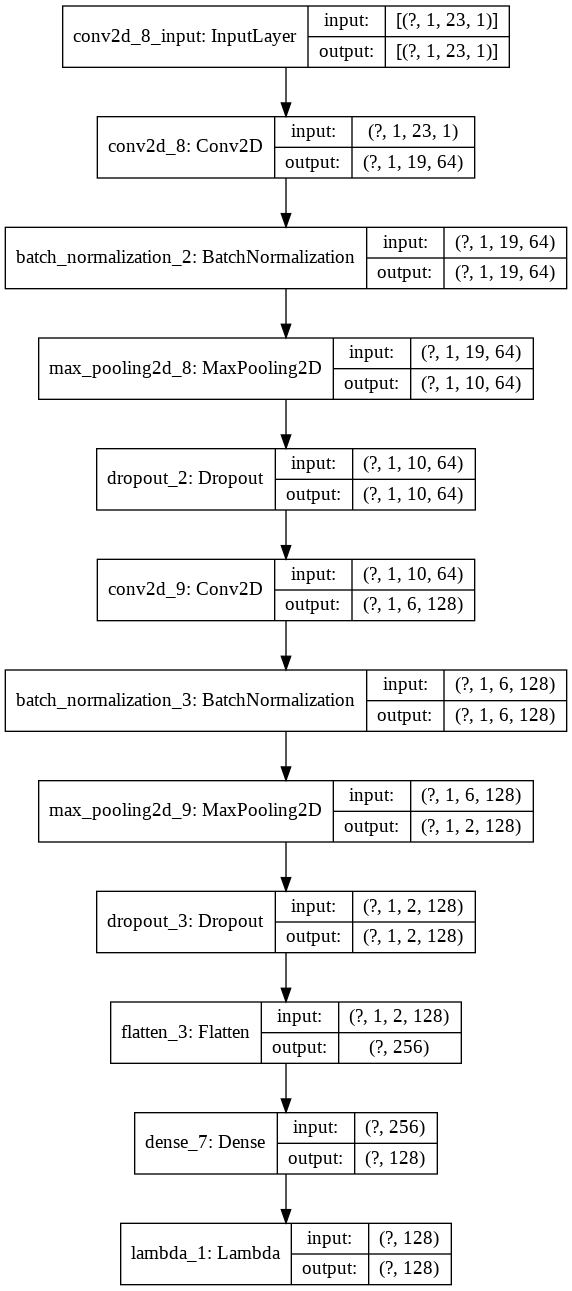

In [ ]:
plot_model(embedding_model, to_file = dnn_path + 'EmbeddingModel.png', show_shapes=True)

## **Siamese Network**

### **Model**

In [ ]:
in_anc = Input(shape=(1,23,1))
in_pos = Input(shape=(1,23,1))
in_neg = Input(shape=(1,23,1))

em_anc = embedding_model(in_anc)
em_pos = embedding_model(in_pos)
em_neg = embedding_model(in_neg)

out = concatenate([em_anc, em_pos, em_neg], axis=1)


### **Triplet Generation- APN pairs**

In [ ]:
# batch_size = 500
# X_train, X_test = generate_triplet(batch_size)

In [ ]:
X_train, X_test = generate_triplet_v2(x_train_oversample, y_train_oversample, ap_pairs=200, an_pairs=200, testsize=0.3)
print("X train  data shape: ",X_train.shape)
print("X test  data shape: ",X_test.shape)

Successfully generated train and test triplets....
X train  data shape:  (56000, 3, 23)
X test  data shape:  (24000, 3, 23)


In [ ]:
X_train.shape, X_test.shape

((56000, 3, 23), (24000, 3, 23))

In [ ]:
Anchor = X_train[:,0,:].reshape(-1,1,23,1)
Positive = X_train[:,1,:].reshape(-1,1,23,1)
Negative = X_train[:,2,:].reshape(-1,1,23,1)
Anchor_test = X_test[:,0,:].reshape(-1,1,23,1)
Positive_test = X_test[:,1,:].reshape(-1,1,23,1)
Negative_test = X_test[:,2,:].reshape(-1,1,23,1)

Y_train_dummy = np.empty((Anchor.shape[0],2))
Y_test_dummy = np.empty((Anchor_test.shape[0],2))


### **Model Training**

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD


custom_adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999)
custom_sgd = SGD(lr=0.001 , clipvalue=1)


bestModelPath=os.path.join(dnn_path,"SiameseNetwork.hdf5")
checkpoint = ModelCheckpoint(filepath=bestModelPath, verbose=0, save_best_only=True)
siamese_model = Model( inputs=[in_anc, in_pos, in_neg], outputs=out)
siamese_model.compile(loss=triplet_loss_v1(alpha=0.8, emb_dim=emb_size), optimizer=custom_adam)

for i in range(5):
  print(f"ITERATION {i+1} ------------------------->")
  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=5, verbose=1, mode='auto')
  siamese_model.fit([Anchor,Positive,Negative], y=Y_train_dummy, validation_data=([Anchor_test,Positive_test,Negative_test], Y_test_dummy), callbacks=[monitor,checkpoint], epochs=100, verbose=2)

siamese_model.load_weights(bestModelPath)


ITERATION 1 ------------------------->
Epoch 1/100
1750/1750 - 9s - loss: 0.1734 - val_loss: 0.0677
Epoch 2/100
1750/1750 - 8s - loss: 0.0362 - val_loss: 0.0528
Epoch 3/100
1750/1750 - 8s - loss: 0.0161 - val_loss: 0.0529
Epoch 4/100
1750/1750 - 9s - loss: 0.0103 - val_loss: 0.0569
Epoch 5/100
1750/1750 - 9s - loss: 0.0077 - val_loss: 0.0508
Epoch 6/100
1750/1750 - 8s - loss: 0.0054 - val_loss: 0.0701
Epoch 7/100
1750/1750 - 8s - loss: 0.0049 - val_loss: 0.0512
Epoch 8/100
1750/1750 - 9s - loss: 0.0035 - val_loss: 0.0599
Epoch 9/100
1750/1750 - 8s - loss: 0.0034 - val_loss: 0.0545
Epoch 10/100
1750/1750 - 8s - loss: 0.0027 - val_loss: 0.0758
Epoch 00010: early stopping
ITERATION 2 ------------------------->
Epoch 1/100
1750/1750 - 9s - loss: 0.0027 - val_loss: 0.0627
Epoch 2/100
1750/1750 - 8s - loss: 0.0019 - val_loss: 0.0632
Epoch 3/100
1750/1750 - 8s - loss: 0.0020 - val_loss: 0.0689
Epoch 4/100
1750/1750 - 8s - loss: 0.0018 - val_loss: 0.0824
Epoch 5/100
1750/1750 - 8s - loss: 0.00

In [ ]:
# from tensorflow.keras import Model
# from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras.callbacks import ModelCheckpoint
# from tensorflow.keras.optimizers import Adam, SGD


# custom_adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999)
# custom_sgd = SGD(lr=0.001 , clipvalue=1)


# #bestModelPath=os.path.join(dnn_path,"SiameseNetwork.hdf5")
# #checkpoint = ModelCheckpoint(filepath=bestModelPath, verbose=0, save_best_only=True)
# siamese_model = Model( inputs=[in_anc, in_pos, in_neg], outputs=out)
# siamese_model.compile(loss=triplet_loss_v1(alpha=0.6, emb_dim=emb_size), optimizer=custom_adam)
# #monitor = EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=5, verbose=1, mode='auto')
# siamese_model.fit([Anchor,Positive,Negative], y=Y_train_dummy, validation_data=([Anchor_test,Positive_test,Negative_test], Y_test_dummy), epochs=100, verbose=2)

# #siamese_model.load_weights(bestModelPath)

In [ ]:
#siamese_model.summary()

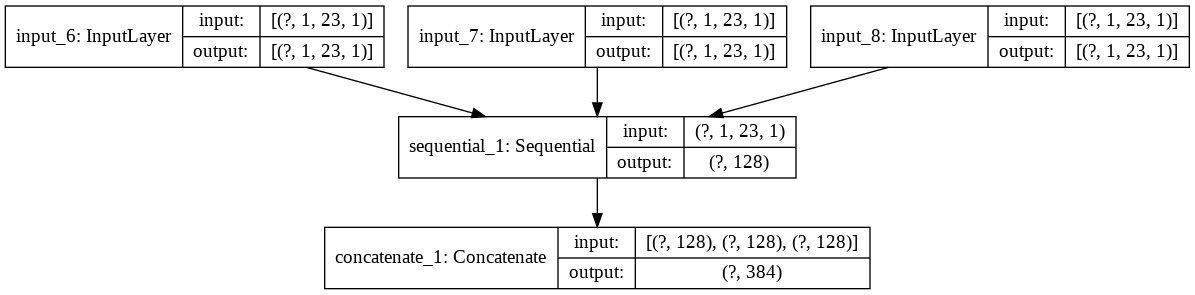

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(siamese_model, to_file = dnn_path + 'SiameseModel.png', show_shapes=True)

### **Anchor Encoding Model**

In [ ]:
trained_model = Model(inputs=in_anc, outputs=em_anc)

trained_model.load_weights(bestModelPath)

## **Embedding after Siamese Network Training**

In [ ]:
tsne = TSNE()
X_train_trm = trained_model.predict(x_train.reshape(x_train.shape[0], 1, 23 ,1))
X_test_trm = trained_model.predict(x_test.reshape(x_test.shape[0], 1, 23 ,1))

train_tsne_embeds = tsne.fit_transform(X_train_trm)
test_tsne_embeds = tsne.fit_transform(X_test_trm)

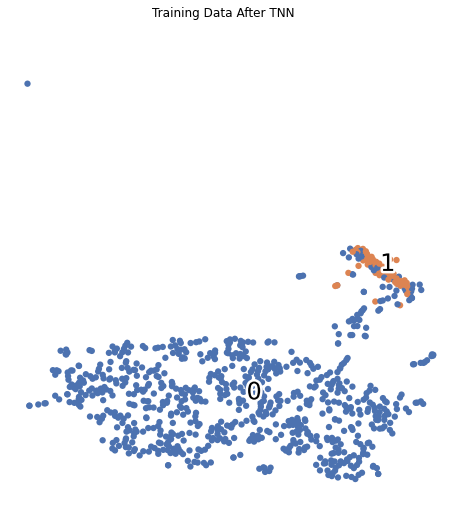

In [ ]:
scatter(train_tsne_embeds, np_classes_train, "Training Data After TNN")

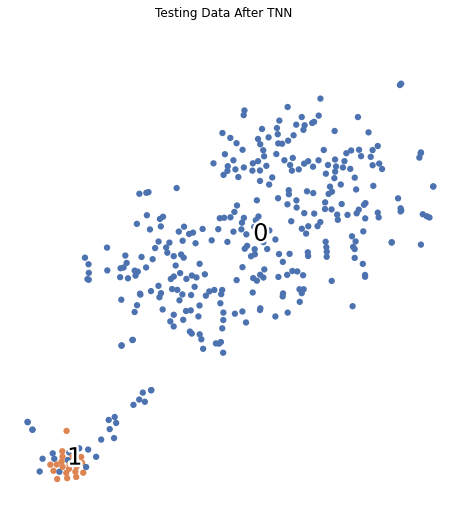

In [ ]:
scatter(test_tsne_embeds, np_classes_test, "Testing Data After TNN")

In [ ]:
X_train_trm.shape

(821, 128)

## **DownStream Classifier Model**

In [ ]:
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Dense
# from tensorflow.keras.optimizers import SGD

# custom_sgd = SGD(lr=0.001, clipvalue=0.5)

# classifier_input = Input(shape=(128,))
# hidden21 = Dense(64, activation='relu')(classifier_input)
# hidden22 = Dense(32, activation='relu')(hidden21)
# hidden23 = Dense(12, activation='relu')(hidden22)
# classifier_output = Dense(2, activation='softmax')(hidden23)

# Classifier_model = Model(classifier_input, classifier_output)

# Classifier_model.compile(optimizer="sgd", loss='binary_crossentropy', metrics=['accuracy'])

# Classifier_model.fit(X_train_trm,y_train,epochs=100)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import SGD


input1 = Input(shape=(16, 8, 1))

conv2 = Conv2D(128, kernel_size=(2, 2), activation='relu')(input1)
pool3 = MaxPooling2D(pool_size=(1, 2))(conv2)

conv4 = Conv2D(64, kernel_size=(2, 2), activation='relu')(pool3)
pool5 = MaxPooling2D(pool_size=(1, 2))(conv4)

conv6 = Conv2D(32, kernel_size=(2, 1), activation='relu')(pool5)
pool7 = MaxPooling2D(pool_size=(2, 1))(conv6)

cnn_flat8 = Flatten()(pool7)

dense9 = Dense(64, activation='relu')(cnn_flat8)
dense10 = Dense(32, activation='relu')(dense9)

cnn_output = Dense(2, activation="softmax")(dense10)

print("Successfully added classification model layers")

Successfully added classification model layers


In [ ]:
X_train_trm = X_train_trm.reshape(X_train_trm.shape[0], 16, 8, 1)
X_test_trm = X_test_trm.reshape(X_test_trm.shape[0], 16, 8, 1)

filepath_savemodel = os.path.join(dnn_path,"downstream.hdf5")
# checkpoint to save the best weights 
checkpoint = ModelCheckpoint(filepath= filepath_savemodel, verbose=0, save_best_only=True)

Classifier_model = Model(inputs= input1, outputs=cnn_output)
Classifier_model.compile(optimizer="adam", loss='categorical_crossentropy')

for i in range(5):
  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=3, verbose=1, mode='auto')
  Classifier_model.fit(X_train_trm,y_train, epochs=100, validation_data=(X_test_trm, y_test))


Epoch 1/100
26/26 [==============================] - 0s 9ms/step - loss: 0.5079 - val_loss: 0.1570
Epoch 2/100
26/26 [==============================] - 0s 4ms/step - loss: 0.1131 - val_loss: 0.0642
Epoch 3/100
26/26 [==============================] - 0s 4ms/step - loss: 0.0896 - val_loss: 0.0574
Epoch 4/100
26/26 [==============================] - 0s 4ms/step - loss: 0.0939 - val_loss: 0.0590
Epoch 5/100
26/26 [==============================] - 0s 4ms/step - loss: 0.0883 - val_loss: 0.0592
Epoch 6/100
26/26 [==============================] - 0s 4ms/step - loss: 0.0833 - val_loss: 0.0558
Epoch 7/100
26/26 [==============================] - 0s 4ms/step - loss: 0.0809 - val_loss: 0.0576
Epoch 8/100
26/26 [==============================] - 0s 4ms/step - loss: 0.0803 - val_loss: 0.0567
Epoch 9/100
26/26 [==============================] - 0s 4ms/step - loss: 0.0812 - val_loss: 0.0544
Epoch 10/100
26/26 [==============================] - 0s 4ms/step - loss: 0.0842 - val_loss: 0.0550
Epoch 11/

In [ ]:
# pred = Classifier_model.predict(X_train_trm)

# pred = np.argmax(pred, axis=1)
# print(pred.shape)

# print(pd.value_counts(np_classes_train))
# print()
# print(pd.value_counts(pred))

In [ ]:
# labels=['Non-AKI', 'AKI']
# gplot.performance_metrics(pred, y_train, labels, "AKI Prediction for Training Dataset", plotROC=True, isNeuralNet=True)

### **Model Evaluation Results**

In [ ]:
pred = Classifier_model.predict(X_test_trm)

pred = np.argmax(pred, axis=1)
pred.shape

print(pd.value_counts(np_classes_test))
print()
print(pd.value_counts(pred))

0    331
1     21
dtype: int64

0    327
1     25
dtype: int64


AKI Prediction for Testing Dataset
---------------------------------------
Accuracy score: 0.9829545454545454
Precision score: 0.9851925215457326
Recall score: 0.9829545454545454
F1 score: 0.9836438422816776


[[326   5]
 [  1  20]]


Plotting confusion matrix


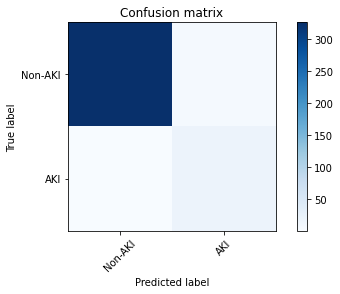



              precision    recall  f1-score   support

           0       1.00      0.98      0.99       331
           1       0.80      0.95      0.87        21

    accuracy                           0.98       352
   macro avg       0.90      0.97      0.93       352
weighted avg       0.99      0.98      0.98       352




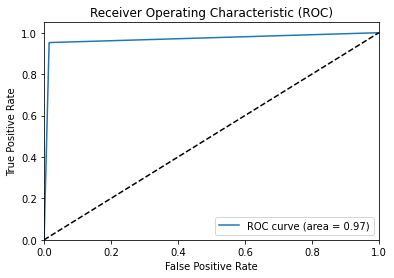

In [ ]:
labels=['Non-AKI', 'AKI']
gplot.performance_metrics(pred, y_test, labels, "AKI Prediction for Testing Dataset", plotROC=True, isNeuralNet=True)